In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as ttd

from datetime import datetime

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2020-12-18 08:58:14--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.31.80.48, 104.31.81.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.01s   

2020-12-18 08:58:14 (39.5 MB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
df = pd.read_csv("spam.csv", encoding="ISO-8859-1")

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.rename(mapper={"v1": "lables", "v2": "data"}, axis=1, inplace=True)

In [8]:
df.head()

,lables,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df["b_labels"] = df["lables"].map({"ham": 0, "spam": 1})

In [10]:
df.head()

,lables,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [11]:
df2 = df[["b_labels", "data"]]

In [12]:
df2.head()

,b_labels,data
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
df2.to_csv("spam2.csv", index=False)

In [26]:
TEXT = ttd.Field(sequential=True, 
                 lower=True, 
                 batch_first=True, 
                 pad_first=True)
LABEL = ttd.Field(sequential=False, 
                  use_vocab=False, 
                  is_target=True)

In [27]:
dataset = ttd.TabularDataset(path="spam2.csv", 
                   format="csv", 
                   skip_header=True, 
                   fields=[("b_labels", LABEL), ("data", TEXT)])

In [28]:
train_dataset, test_dataset = dataset.split()

In [29]:
TEXT.build_vocab(train_dataset)

In [30]:
vocab = TEXT.vocab

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [32]:
train_iter, test_iter = ttd.Iterator.splits((train_dataset, test_dataset), 
                                            batch_sizes=(32, 256), 
                                            sort_key=lambda x: len(x.data), 
                                            device=device)

In [34]:
embed = nn.Embedding(num_embeddings=len(vocab), embedding_dim=20).to(device)
for inputs, targets in train_iter:
    out = embed(inputs)
    print("inputs.shape", inputs.shape, "outputs.shape", out.shape)
    break

inputs.shape torch.Size([32, 162]) outputs.shape torch.Size([32, 162, 20])


In [52]:
class CNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_outputs):
        super(CNN, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.K = n_outputs

        self.embed = nn.Embedding(num_embeddings=self.V, 
                                  embedding_dim=self.D)
        self.conv1 = nn.Conv1d(in_channels=self.D, 
                               out_channels=32, 
                               kernel_size=3, 
                               padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, 
                               out_channels=64, 
                               kernel_size=3, 
                               padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(in_channels=64, 
                               out_channels=128, 
                               kernel_size=3, 
                               padding=1)
        self.fc = nn.Linear(in_features=128, 
                            out_features=self.K)
    
    def forward(self, X):
        out = self.embed(X)
        out = out.permute(0, 2, 1)
        out = self.conv1(out)
        out = F.relu(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = F.relu(out)

        out = out.permute(0, 2, 1)

        out, _ = torch.max(out, 1)

        out = self.fc(out)
        return out

In [53]:
model = CNN(len(vocab), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(10869, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [54]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters())

In [55]:
def batch_gd(model, 
             criterion, 
             optimizer, 
             train_iter, 
             test_iter, 
             epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for epoch in range(epochs):
        t0 = datetime.now()

        train_loss = []
        for inputs, targets in train_iter:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.view(-1, 1).float()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()
        train_loss = np.mean(train_loss)
        train_losses[epoch] = train_loss

        test_loss = []
        for inputs, targets in test_iter:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.view(-1, 1).float()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())

        test_loss = np.mean(test_loss)
        test_losses[epoch] = test_loss
        dt = datetime.now() - t0
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")
    return train_losses, test_losses

In [56]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_iter, test_iter, 8)

Epoch 1/8, Train Loss: 0.4084, Test Loss: 0.4566, Duration: 0:00:00.562978
Epoch 2/8, Train Loss: 0.2973, Test Loss: 0.2413, Duration: 0:00:00.526412
Epoch 3/8, Train Loss: 0.1581, Test Loss: 0.1905, Duration: 0:00:00.526544
Epoch 4/8, Train Loss: 0.1046, Test Loss: 0.1710, Duration: 0:00:00.531158
Epoch 5/8, Train Loss: 0.0786, Test Loss: 0.1471, Duration: 0:00:00.528451
Epoch 6/8, Train Loss: 0.0558, Test Loss: 0.1464, Duration: 0:00:00.541799
Epoch 7/8, Train Loss: 0.0342, Test Loss: 0.1506, Duration: 0:00:00.521534
Epoch 8/8, Train Loss: 0.0291, Test Loss: 0.1412, Duration: 0:00:00.541424


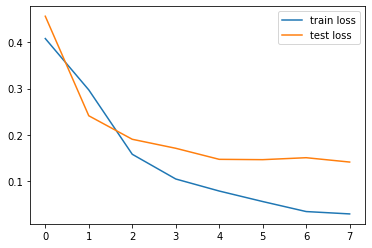

In [57]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [59]:
n_correct = 0
n_total = 0
for inputs, targets in train_iter:
    inputs, targets = inputs.to(device), targets.to(device)
    targets = targets.view(-1, 1).float()

    outputs = model(inputs)
    predictions = (outputs > 0)
    n_correct += (predictions == targets).sum().item()
    n_total += inputs.shape[0]  
train_acc = n_correct / n_total

n_correct = 0
n_total = 0
for inputs, targets in test_iter:
    inputs, targets = inputs.to(device), targets.to(device)
    targets = targets.view(-1, 1).float()

    outputs = model(inputs)
    predictions = (outputs > 0)
    n_correct += (predictions == targets).sum().item()
    n_total += inputs.shape[0]  
test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9931, Test acc: 0.9551
